In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import veros.core.density.nonlinear_eq2 as neq2
from matplotlib import colors
import plotting_function_avg as pltfunc
import diagnostic_function as diagf
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import glob



Importing core modules
 Using computational backend numpy on cpu
 Runtime settings are now locked



In [3]:
ds_snap =xr.open_dataset("/home/x_titmo/work/runs_output/NW2_clim/Dino_clim_bis"  + "/nw2_dino.0000.snapshot.nc", decode_times=False)
land_mask = (ds_snap.zt.to_numpy()[:,np.newaxis, np.newaxis] <= -ds_snap.bathymetry.to_numpy()[np.newaxis,...]) | (ds_snap.salt.isel(Time=0).drop_vars("Time") == 0.0)

weight_xyz_t = (1-land_mask) * ds_snap.area_t * ds_snap.dzt
weight_xyz_t = weight_xyz_t.fillna(0) / weight_xyz_t.sum()
weights_xy_t = weight_xyz_t / weight_xyz_t.sum('xt').sum('yt')
weights_z_t = weight_xyz_t.mean(dim=('xt','yt'))

land_mask_W = xr.DataArray(land_mask.values, dims=('zw', 'yt', 'xt'), coords={'zw': ds_snap.zw, 'yt': ds_snap.yt, 'xt': ds_snap.xt})

weight_xyz_w = (1-land_mask_W) * ds_snap.area_t * ds_snap.dzw
weight_xyz_w = weight_xyz_w.fillna(0) / weight_xyz_w.sum()
weights_xy_w = weight_xyz_w / weight_xyz_w.sum('xt').sum('yt')
weights_z_w = weight_xyz_w.mean(dim=('xt','yt'))

weight_surf = ds_snap.area_t.fillna(0)
weight_surf =weight_surf/ weight_surf.sum('xt').sum('yt')

In [4]:
def name_of_files(key='Clim', field='averages', i_max = 100, ) :
    file_pattern = "/home/x_titmo/work/runs_output/NW2_clim/" + key + "/*" + field +".nc"
    all_files = sorted(glob.glob(file_pattern))
    all_files_suite=[]
    if key=='NoW':
          all_files_suite = sorted(glob.glob("/home/x_titmo/work/runs_output/NW2_clim/NoW/NoW_suite/"+ "/*" + field +".nc"))
    if key=='Dino_clim_bis':
          all_files_suite = sorted(glob.glob("/home/x_titmo/work/runs_output/NW2_clim/Dino_clim_bis/Dino_clim_bis_suite/"+ "/*" + field +".nc"))
    OUTPUT_FILES = all_files[:i_max] + all_files_suite[:]
    print(len(OUTPUT_FILES), OUTPUT_FILES[-1])
    return OUTPUT_FILES

CLIM_BIS = name_of_files(key='Dino_clim_bis', field='averages')[:-1]
CLIM_BIS_OVR = name_of_files(key='Dino_clim_bis', field='overturning')[:-1]

NOW = name_of_files(key='NoW', field='averages')[10:-1]
NOW_OVR = name_of_files(key='NoW', field='overturning')[10:-1]

TWO_W = name_of_files(key='2W', field='averages')[2:-1]
TWO_W_OVR = name_of_files(key='2W', field='overturning')[2:-1]

TWO_W_N = name_of_files(key='2W_N', field='averages')[2:-1]
TWO_W_N_OVR = name_of_files(key='2W_N', field='overturning')[2:-1]

TWO_W_SO = name_of_files(key='2W_SO', field='averages')[2:-1]
TWO_W_SO_OVR = name_of_files(key='2W_SO', field='overturning')[2:-1]

MIX_MAX = name_of_files(key='Mix_High', field='averages')[:-1]
MIX_MAX_OVR = name_of_files(key='Mix_High', field='overturning')[:-1]

MIX_MIN = name_of_files(key='Mix_Cte', field='averages')[:-1]
MIX_MIN_OVR = name_of_files(key='Mix_Cte', field='overturning')[:-1]

MIX_MEAN = name_of_files(key='Mix_Mean', field='averages')[:-1]
MIX_MEAN_OVR = name_of_files(key='Mix_Mean', field='overturning')[:-1]

85 /home/x_titmo/work/runs_output/NW2_clim/Dino_clim_bis/Dino_clim_bis_suite/nw2_dino.0019.averages.nc
85 /home/x_titmo/work/runs_output/NW2_clim/Dino_clim_bis/Dino_clim_bis_suite/nw2_dino.0019.overturning.nc
93 /home/x_titmo/work/runs_output/NW2_clim/NoW/NoW_suite/nw2_dino.0042.averages.nc
93 /home/x_titmo/work/runs_output/NW2_clim/NoW/NoW_suite/nw2_dino.0042.overturning.nc
71 /home/x_titmo/work/runs_output/NW2_clim/2W/clim_2w.0070.averages.nc
71 /home/x_titmo/work/runs_output/NW2_clim/2W/clim_2w.0070.overturning.nc
63 /home/x_titmo/work/runs_output/NW2_clim/2W_N/clim_2w_n.0062.averages.nc
63 /home/x_titmo/work/runs_output/NW2_clim/2W_N/clim_2w_n.0062.overturning.nc
63 /home/x_titmo/work/runs_output/NW2_clim/2W_SO/clim_2w_so.0062.averages.nc
63 /home/x_titmo/work/runs_output/NW2_clim/2W_SO/clim_2w_so.0062.overturning.nc
67 /home/x_titmo/work/runs_output/NW2_clim/Mix_High/mix_H.0066.averages.nc
67 /home/x_titmo/work/runs_output/NW2_clim/Mix_High/mix_H.0066.overturning.nc
66 /home/x_tit

In [5]:
def preprocess(ds):
    return ds.isel(Time=slice(0, None, 5*12 * 2))

ds_avg_now      = xr.open_mfdataset(NOW      , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_avg_2w       = xr.open_mfdataset(TWO_W    , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_avg_2w_n     = xr.open_mfdataset(TWO_W_N  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_avg_2w_so     = xr.open_mfdataset(TWO_W_SO  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_avg_mix_max  = xr.open_mfdataset(MIX_MAX  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_avg_mix_min  = xr.open_mfdataset(MIX_MIN  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_avg_mix_mean  = xr.open_mfdataset(MIX_MEAN  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_avg_clim_bis = xr.open_mfdataset(CLIM_BIS , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})

ds_ovr_now      = xr.open_mfdataset(NOW_OVR      , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_ovr_2w       = xr.open_mfdataset(TWO_W_OVR    , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_ovr_2w_n     = xr.open_mfdataset(TWO_W_N_OVR  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_ovr_2w_so     = xr.open_mfdataset(TWO_W_SO_OVR  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_ovr_mix_max  = xr.open_mfdataset(MIX_MAX_OVR  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_ovr_mix_min  = xr.open_mfdataset(MIX_MIN_OVR  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_ovr_mix_mean  = xr.open_mfdataset(MIX_MEAN_OVR  , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})
ds_ovr_clim_bis = xr.open_mfdataset(CLIM_BIS_OVR , combine='nested', concat_dim='Time', data_vars='minimal', coords='minimal', preprocess=preprocess, decode_times=False, chunks={'Time': 50})

datasets_avg = {"Clim_bis" : ds_avg_clim_bis, "NoW" : ds_avg_now, "2W" : ds_avg_2w, "2W_N" : ds_avg_2w_n, "2W_SO" : ds_avg_2w_so, "Mix_Max" : ds_avg_mix_max, "Mix_Min" : ds_avg_mix_min, "Mix_Mean" : ds_avg_mix_mean}
datasets_ovr = {"Clim_bis" : ds_ovr_clim_bis, "NoW" : ds_ovr_now, "2W" : ds_ovr_2w, "2W_N" : ds_ovr_2w_n, "2W_SO" : ds_ovr_2w_so, "Mix_Max" : ds_ovr_mix_max, "Mix_Min" : ds_ovr_mix_min, "Mix_Mean" : ds_ovr_mix_mean}

keys_to_plot =["Clim_bis", "NoW", "2W", "2W_N", "2W_SO", "Mix_Max", "Mix_Min", "Mix_Mean"]

for key in keys_to_plot :
    datasets_avg[key] = datasets_avg[key].assign_coords(years=("Time", (datasets_avg[key].Time / 365).data))
    datasets_ovr[key] = datasets_ovr[key].assign_coords(years=("Time", (datasets_ovr[key].Time / 365).data))

In [6]:
def compute_mean_var_avg(ds):
    mean_temp = ds.temp.weighted(weight_xyz_t).mean(dim=("xt","yt","zt"))
    mean_salt = ds.salt.weighted(weight_xyz_t).mean(dim=("xt","yt","zt"))
    cond = (ds_snap.zt > -2000) & (((1-land_mask)*ds_snap.zt).min(dim='zt')<-2000)

    mean_temp_2000 = ds.temp.where(cond).weighted(weight_xyz_t).mean(dim=("xt","yt","zt"))
    mean_salt_2000 = ds.salt.where(cond).weighted(weight_xyz_t).mean(dim=("xt","yt","zt"))

    zeta_2000, zeta_temp_2000, zeta_salt_2000 = diagf.heigth_anomaly_CoM(ds.salt.where(cond), ds.temp.where(cond),
                                                                        mean_salt_2000, mean_temp_2000, 
                                                                        ds_snap.zt.where(cond), z_v= -1000)

    mean_zeta_2000 = zeta_2000.weighted(weight_xyz_t).mean(dim=('zt', 'xt', 'yt'))
    max_ACC = ds.psi.where(ds.yu<-40).max(dim=('xu', 'yu')) *1e-6

    return mean_temp, mean_salt, mean_zeta_2000, max_ACC


In [7]:
diagnostics = {}

for key, ds in datasets_avg.items():
    mean_temp, mean_salt, mean_zeta_2000, max_ACC = compute_mean_var_avg(datasets_avg[key])
    ds_ovr = datasets_ovr[key]
    rmoc = -(ds_ovr.vsf_depth + ds_ovr.bolus_depth) * 1e-6
    dmoc = rmoc.where(ds_ovr.yu > 30).where(ds_ovr.zw <- 250).max(dim=('zw', 'yu'))
    bottom_cell = rmoc.where((ds_ovr.yu > -40)&(ds_ovr.yu < 40)).where(ds_ovr.zw <- 1000).min(dim=('zw', 'yu'))

    diagnostics[key] = {"mean_temp" : mean_temp, 
                        "mean_salt" : mean_salt, 
                        "mean_zeta_2000" : mean_zeta_2000, 
                        "max_ACC" : max_ACC, 
                        "dmoc" : dmoc,
                        "bottom_cell" : bottom_cell
                        }

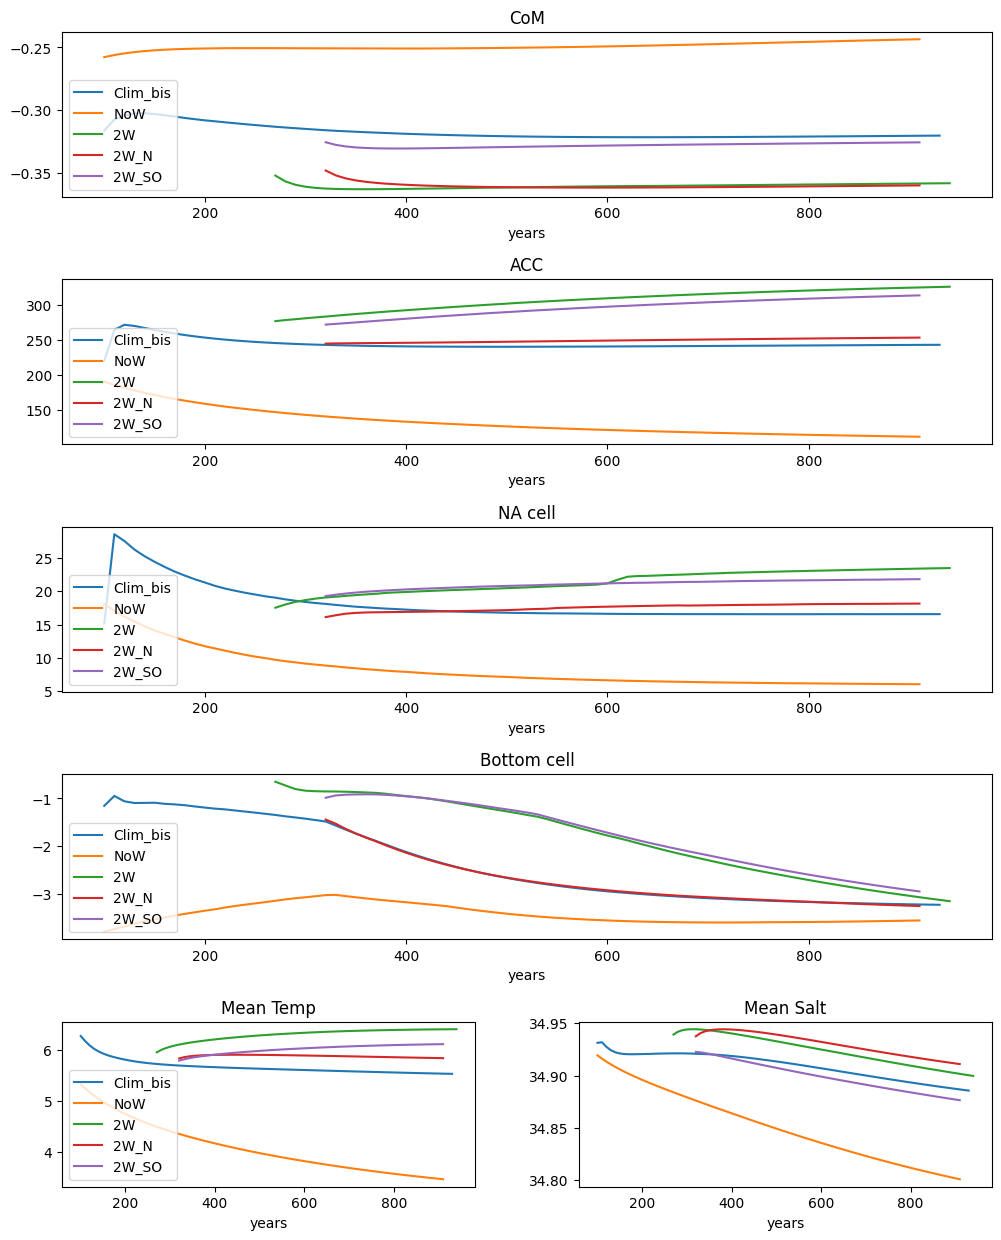

In [13]:
fig = plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(5, 2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1, 1, 1, 1],  wspace=0.25, hspace=0.5)
#gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0,0], width_ratios=[1, 0.04], hspace = 0.25)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])
ax2 = fig.add_subplot(gs[2,:])
ax30, ax31 = fig.add_subplot(gs[4,0]), fig.add_subplot(gs[4,1])
ax4 = fig.add_subplot(gs[3,:])

for key in ["Clim_bis", "NoW", "2W", "2W_N", "2W_SO"] : 
    diagnostics[key]["mean_zeta_2000"].plot(ax=ax0, x='years', label=key)
    diagnostics[key]["max_ACC"].plot(ax=ax1, x='years', label=key)
    diagnostics[key]["dmoc"].plot(ax=ax2, x='years', label=key)
    diagnostics[key]["mean_temp"].plot(ax=ax30, x='years', label=key)
    diagnostics[key]["mean_salt"].plot(ax=ax31, x='years', label=key)
    diagnostics[key]["bottom_cell"].plot(ax=ax4, x='years', label=key)

ax0.set_title(rf'CoM')
ax1.set_title(rf'ACC')
ax2.set_title(rf'NA cell')
ax30.set_title(rf'Mean Temp')
ax31.set_title(rf'Mean Salt')
ax4.set_title(rf'Bottom cell')

ax0.legend(loc='lower left'), ax1.legend(loc='lower left'), ax2.legend(loc='lower left'), ax30.legend(loc='lower left'), ax4.legend(loc='lower left')

#ax0.set_xscale('log'), ax1.set_xscale('log'), ax2.set_xscale('log'), ax30.set_xscale('log'), ax31.set_xscale('log'), ax4.set_xscale('log')
ax0.set_ylabel(''), ax1.set_ylabel(''), ax2.set_ylabel(''), ax30.set_ylabel(''), ax31.set_ylabel(''), ax4.set_ylabel('')

plt.show()

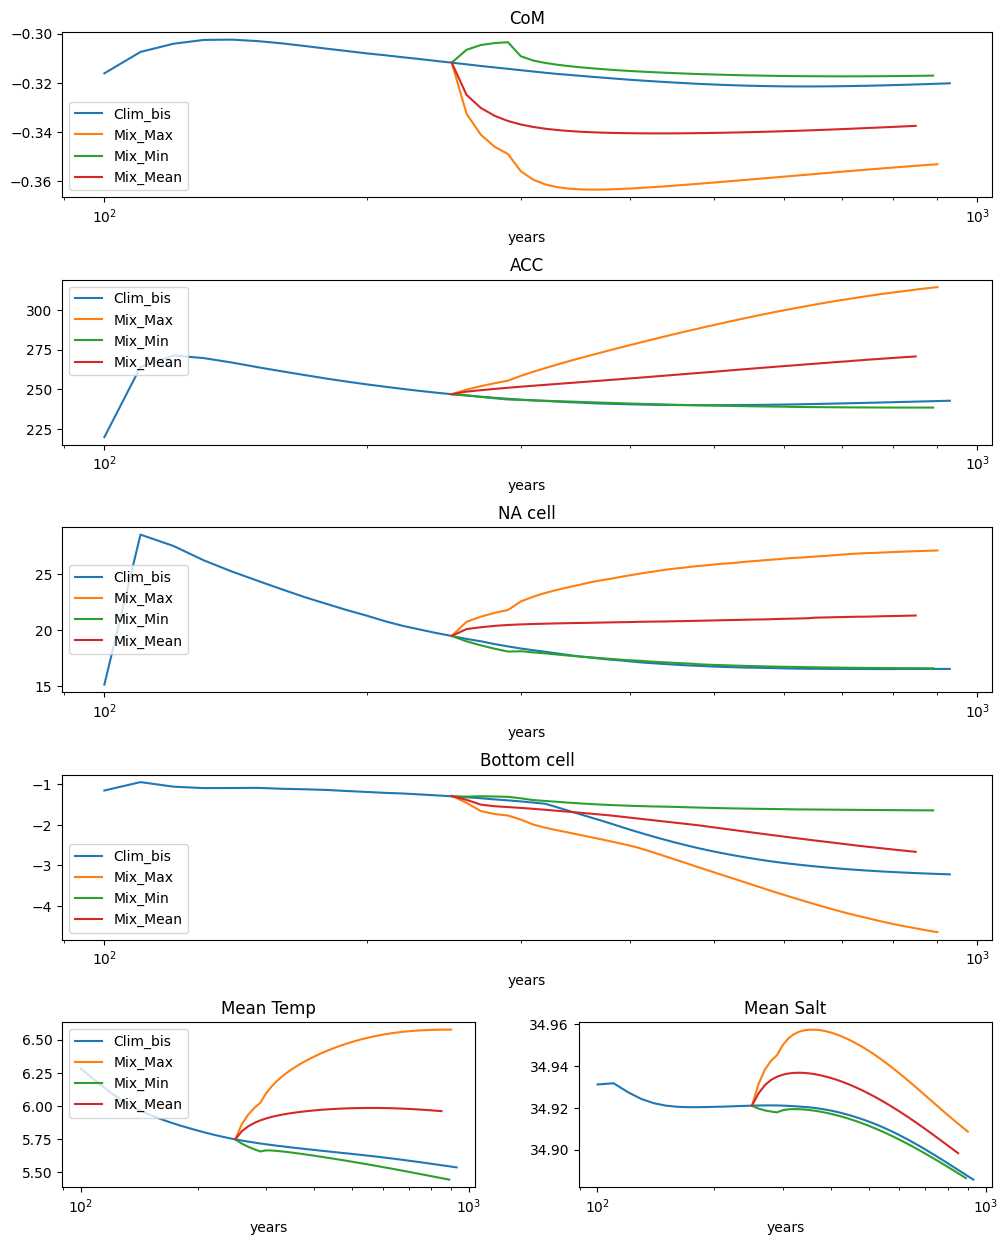

In [11]:
fig = plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(5, 2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1, 1, 1, 1],  wspace=0.25, hspace=0.5)
#gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0,0], width_ratios=[1, 0.04], hspace = 0.25)

ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])
ax2 = fig.add_subplot(gs[2,:])
ax30, ax31 = fig.add_subplot(gs[4,0]), fig.add_subplot(gs[4,1])
ax4 = fig.add_subplot(gs[3,:])

for key in ["Clim_bis", "Mix_Max", "Mix_Min", "Mix_Mean"] : 
    diagnostics[key]["mean_zeta_2000"].plot(ax=ax0, x='years', label=key)
    diagnostics[key]["max_ACC"].plot(ax=ax1, x='years', label=key)
    diagnostics[key]["dmoc"].plot(ax=ax2, x='years', label=key)
    diagnostics[key]["mean_temp"].plot(ax=ax30, x='years', label=key)
    diagnostics[key]["mean_salt"].plot(ax=ax31, x='years', label=key)
    diagnostics[key]["bottom_cell"].plot(ax=ax4, x='years', label=key)

ax0.set_title(rf'CoM')
ax1.set_title(rf'ACC')
ax2.set_title(rf'NA cell')
ax30.set_title(rf'Mean Temp')
ax31.set_title(rf'Mean Salt')
ax4.set_title(rf'Bottom cell')

ax0.legend(), ax1.legend(), ax2.legend(), ax30.legend(), ax4.legend()

ax0.set_xscale('log'), ax1.set_xscale('log'), ax2.set_xscale('log'), ax30.set_xscale('log'), ax31.set_xscale('log'), ax4.set_xscale('log')
ax0.set_ylabel(''), ax1.set_ylabel(''), ax2.set_ylabel(''), ax30.set_ylabel(''), ax31.set_ylabel(''), ax4.set_ylabel('')

plt.show()